**QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.

You're given a [CSV file](#) containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.


In [2]:
import pandas as pd

In [3]:
medical_df = pd.read_csv('medical.csv')

In [4]:
medical_df

age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]

The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children,smoking habits and region.

Let's check the data type for each column.

In [6]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" (body mass index) and "charges" are numbers, whereas "sex",
"smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical

In [8]:
medical_df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

# Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization.

In [11]:
import plotly.express as px
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [12]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14 
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [14]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [15]:
fig = px.histogram(medical_df,
                   x='age',
                   marginal='box',
                   nbins=47, # (64-18) + 1 = 47 (one for each age)
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.
The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.

## Body Mass Index
Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [18]:
fig = px.histogram(medical_df, x='bmi', marginal='box',color_discrete_sequence=['red'],title='Distribution of BMI')
fig.update_layout(bargap=0.1)
fig.show()

## Charges
Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [20]:
fig = px.histogram(medical_df,
                   x='charges', 
                   marginal='box',
                   color='smoker',
                   color_discrete_sequence=['green','grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

- For most customers, the annual medical charges are under **$10,000**. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a *"power law"*

- There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is **$7300**.

- the median for smokers is close to **$35,000**.

> **EXERCISE**: Visualize the distribution of medical charges in connection with other factors like *"sex"* and *"region"*. What do you observe?


In [22]:
fig = px.histogram(medical_df,
                   x='charges', 
                   marginal='box',
                   color='sex',
                   color_discrete_sequence=['green','grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

In [23]:
fig = px.histogram(medical_df,
                   x='charges', 
                   marginal='box',
                   color='region',
                   color_discrete_sequence=['green','grey','blue','red'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

## Smoker
Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [25]:
medical_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [26]:
px.histogram(medical_df,x='smoker',color='sex',title='smoker')

It appears that 20% of customers have reported that they smoke. Can you verify whether this matches the national average, assuming the data was collected in 2010? We can also see that smoking appears a more common habit among males. Can you verify this?

Having looked at individual columns, we can now visualize the relationship between "charges" (the value we wish to predict) and other columns.

## Age and Charges
Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [29]:
fig = px.scatter(medical_df,
                 x='age',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='Age vs. Charges'
                )
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

- The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

- We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

    1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others  
    2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".  
    3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.


## BMI and Charges
Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [32]:
fig = px.scatter(medical_df,
                 x='bmi',
                 y='charges',
                 color='smoker',
                 opacity=0.7,
                 hover_data=['sex'],
                 title='BMI vs. Charges'
                )
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in **"charges"** compared to other columns. E.g. **"age"** and **"charges"** seem to grow together, whereas **"bmi"** and **"charges"** don't.

This relationship is often expressed numerically using a measure called the *correlation coefficient*, which can be computed using the `.corr` method of a Pandas series.


In [35]:
medical_df.charges.corr(medical_df.age)

0.2990081933306478

In [36]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362887

In [37]:
medical_df.charges.corr(medical_df.children)

0.06799822684790487

To compute the correlation for categorical columns, they must firts be converted into numeric columns. 

In [39]:
medical_df.smoker

0       yes
1        no
2        no
3        no
4        no
       ... 
1333     no
1334     no
1335     no
1336     no
1337    yes
Name: smoker, Length: 1338, dtype: object

In [40]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
smoker_numeric

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64

In [41]:
medical_df.charges.corr(smoker_numeric)

0.7872514304984778

Here's how correlation coefficients can be interpreted:

- **Strength**: The greater the absolute value of the correlation coefficient, the stronger the relationship.  
  - The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.  
  - A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.  
  - When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.

- **Direction**: The sign of the correlation coefficient represents the direction of the relationship.  
  - Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.  
  - Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Here's the same relationship expressed visually ([source](#)):

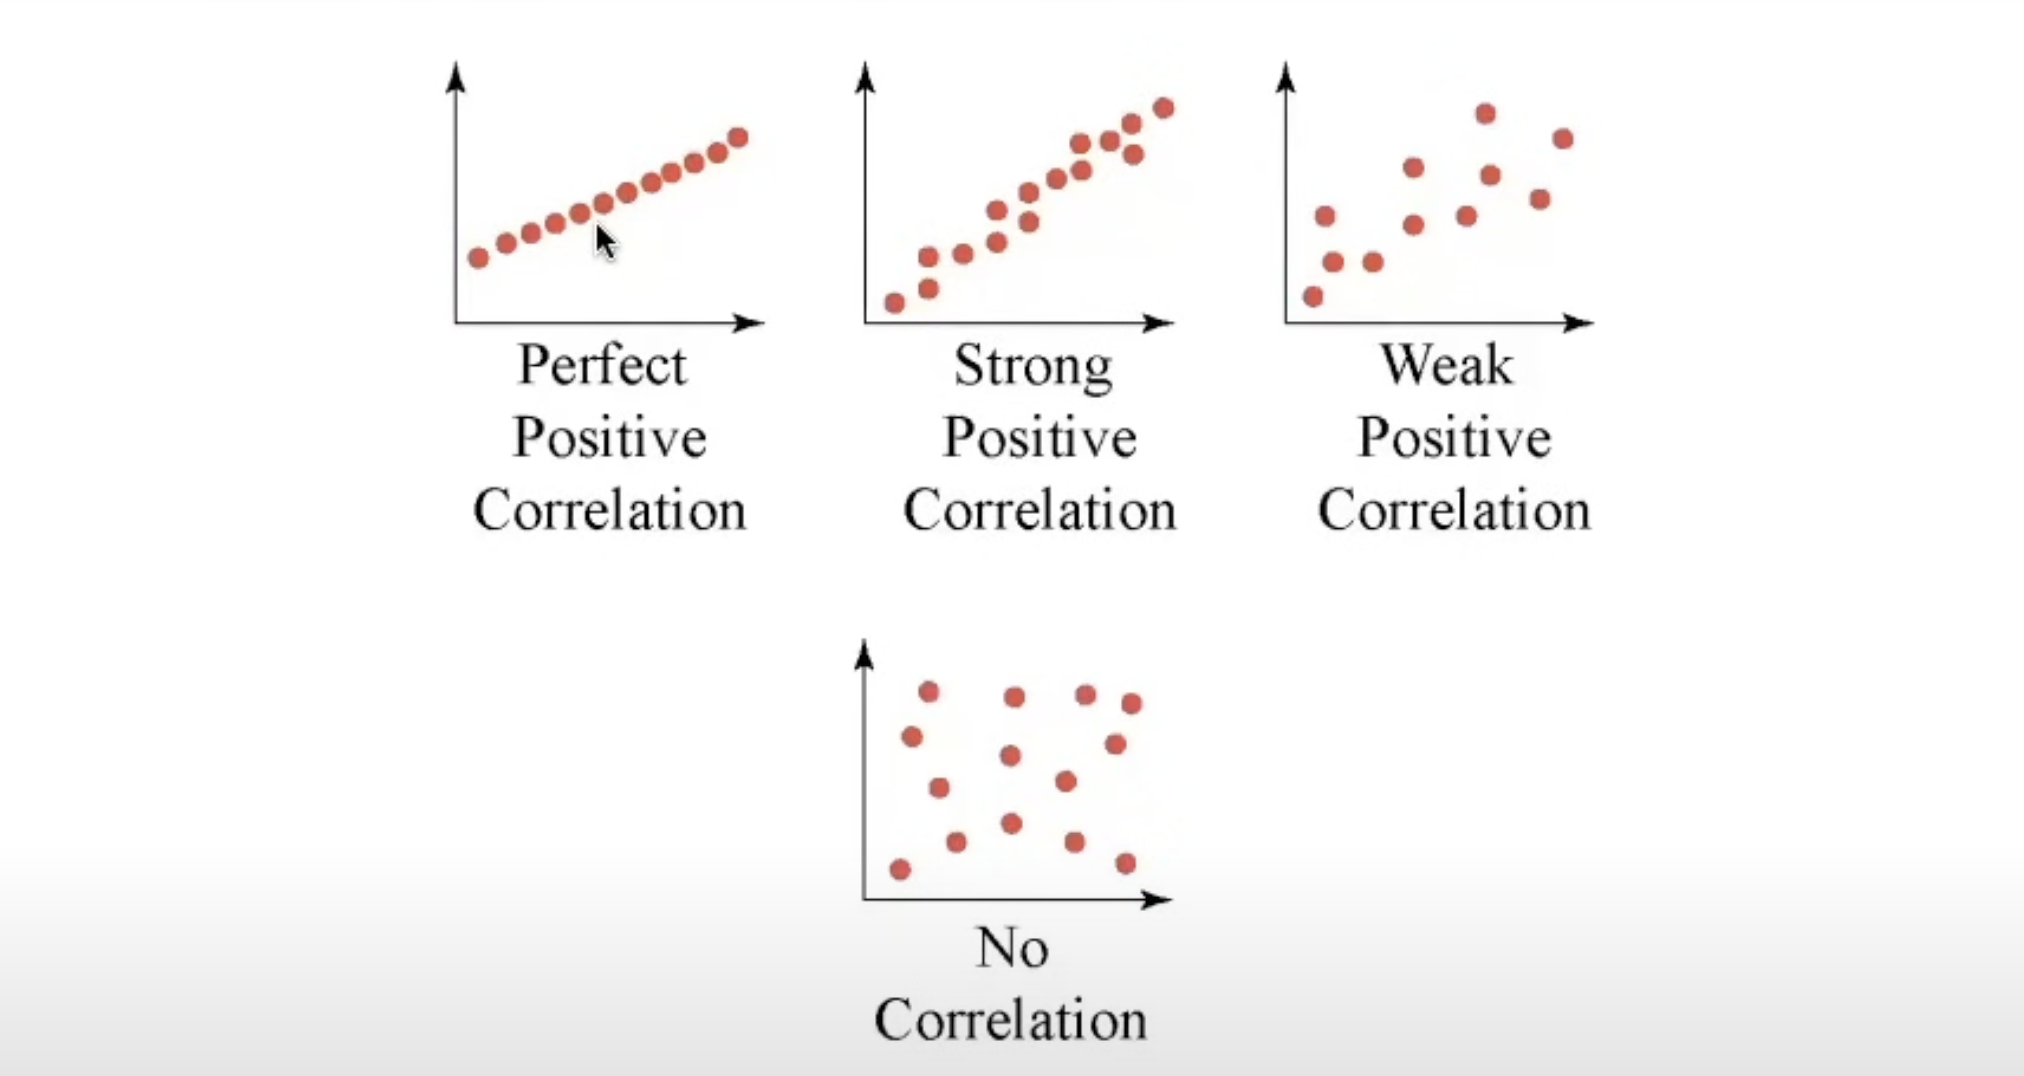
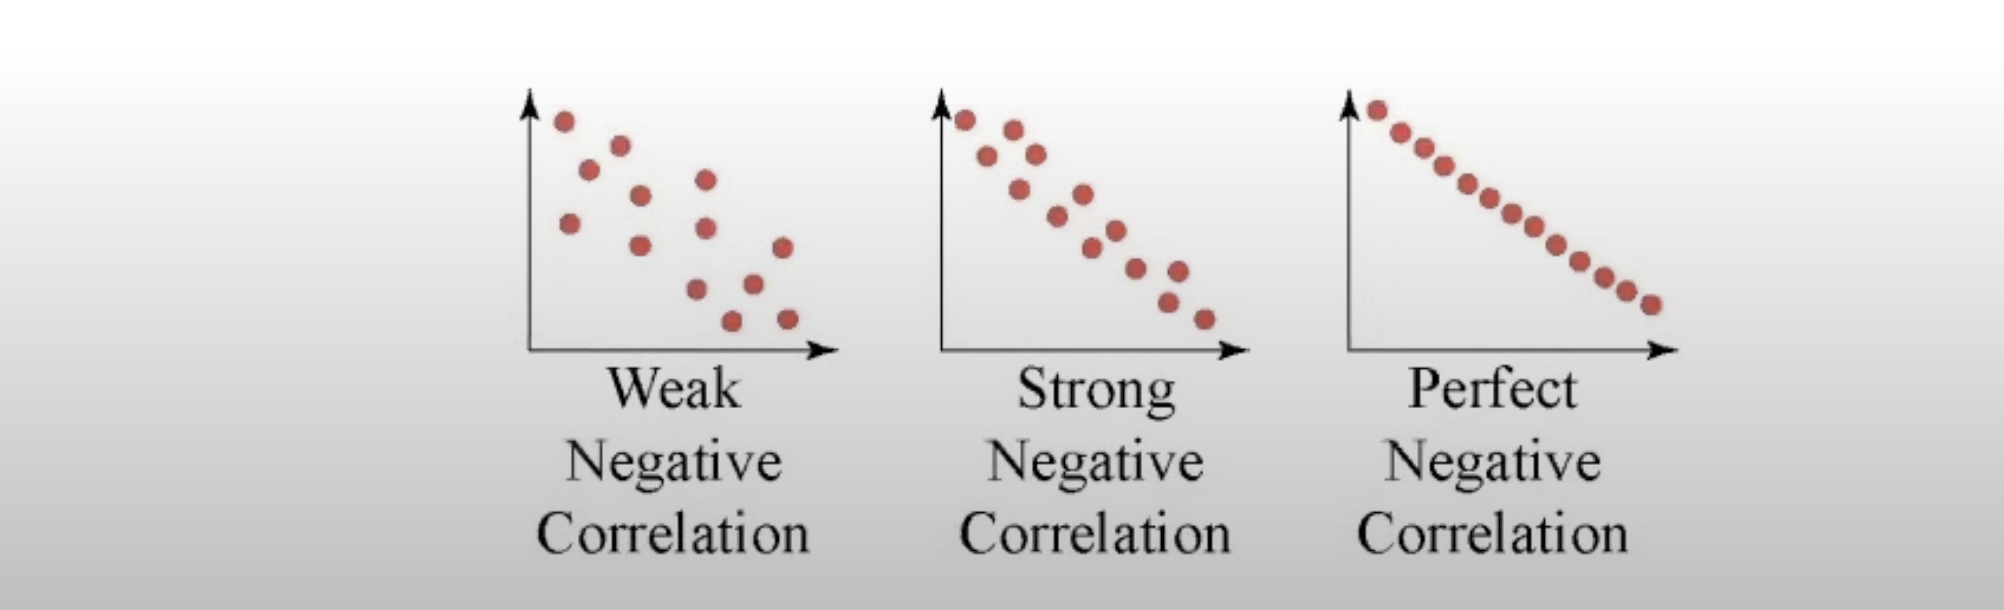
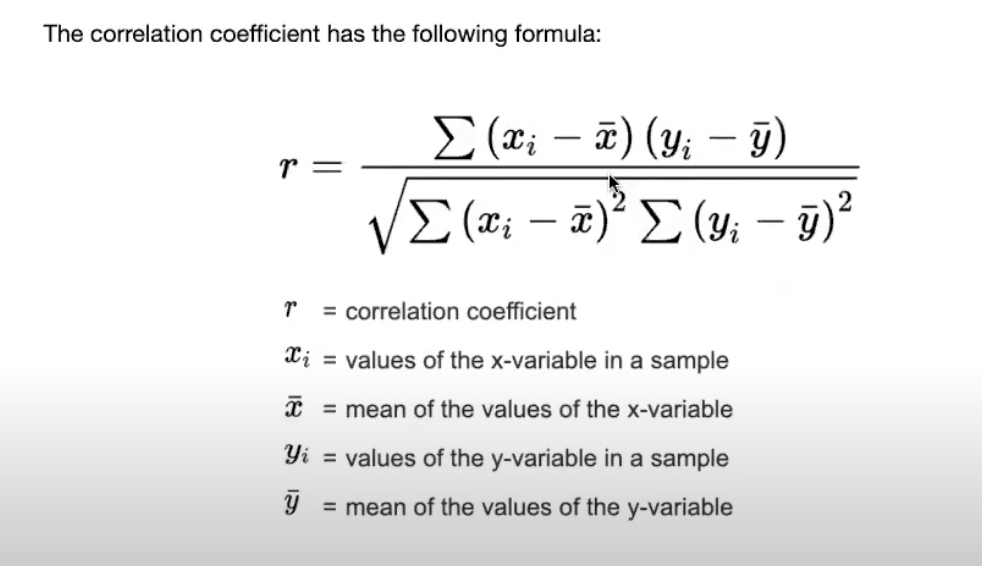

Pandas dataframes also provide a .corr method to compute the correlation coefficients between all pairs of numeric columns.

In [69]:
medical_df_numeric = medical_df.select_dtypes(include='number')
corr_matrix = medical_df_numeric.corr()
corr_matrix

age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000

The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

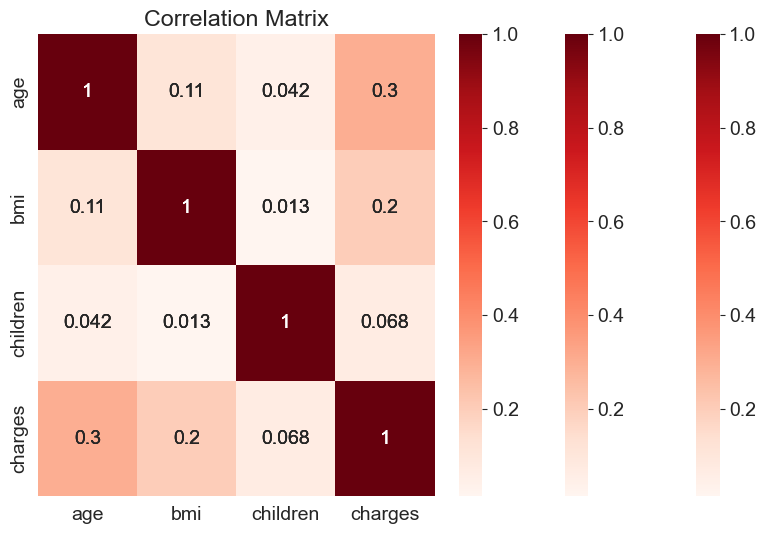

In [81]:
sns.heatmap(corr_matrix, cmap='Reds', annot=True)
plt.title('Correlation Matrix')
plt.show()


**Correlation vs causation fallacy:**  
Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features *X* and *Y* can be correlated if *X* causes *Y* or if *Y* causes *X*, or if both are caused independently by some other factor *Z*, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that *X* are *Y* simply appear to be correlated because the sample is too small.

While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated systems can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.


## Linear Regression using a Single Feature
We now know that the "smoker" and "age" columns have the strongest correlation with "charges" Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers. 

In [107]:
non_smoker_df = medical_df[medical_df.smoker == 'no']
non_smoker_df

age     sex     bmi  children smoker     region      charges
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
5      31  female  25.740         0     no  southeast   3756.62160
...   ...     ...     ...       ...    ...        ...          ...
1332   52  female  44.700         3     no  southwest  11411.68500
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500

[1064 rows x 7 columns]

Next, Let's visualize the relationship between 'Age' and 'Charges'

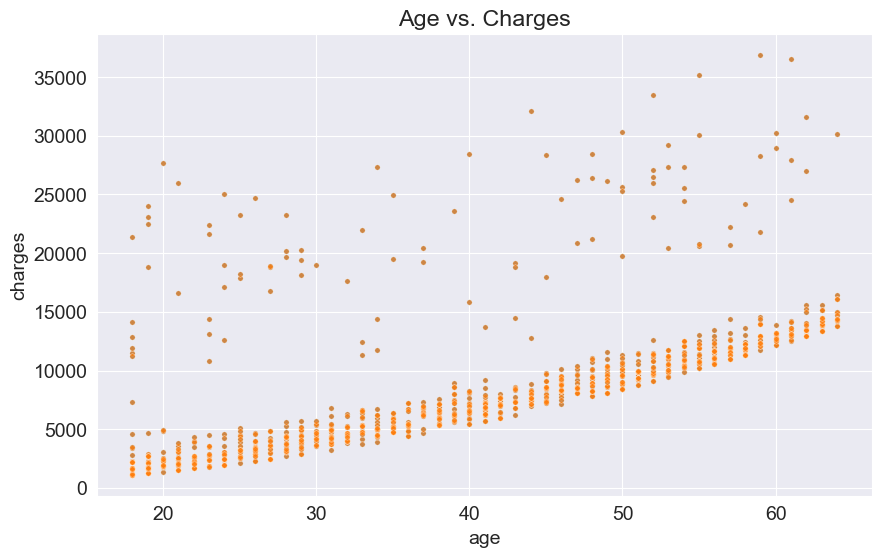

In [89]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15)
plt.show()

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

$$
y = wx + b
$$

The line is characterized two numbers: *w* (called "slope") and *b* (called "intercept").

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:

$$
charges = w \times age + b
$$

We'll try determine *w* and *b* for the line that best fits the data.

- This technique is called *linear regression*, and we call the above equation a *linear regression model*, because it models the relationship between "age" and "charges" as a straight line.
- The numbers *w* and *b* are called the *parameters* or *weights* of the model.
- The values in the "age" column of the dataset are called the *inputs* to the model and the values in the charges column are called "targets".

Let define a helper function `estimate_charges`, to compute *charges*, given *age*, *w* and *b*.


In [93]:
def estimate_charges(age, w, b): 
    return w * age + b

The `estimate_charges` function is our very first model. 

Let's guess the values for `w` and `b` and use them to estimate the value for charges. 

In [97]:
w = 50 
b= 100 

In [101]:
estimate_charges(30,w,b)

1600

In [103]:
estimate_charges(40,w,b)

2100

In [105]:
ages = non_smoker_df.age 
ages

1       18
2       28
3       33
4       32
5       31
        ..
1332    52
1333    50
1334    18
1335    18
1336    21
Name: age, Length: 1064, dtype: int64

In [109]:
estimated_charges = estimate_charges(ages,w,b)
estimated_charges 

1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64

In [111]:
non_smoker_df.charges

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

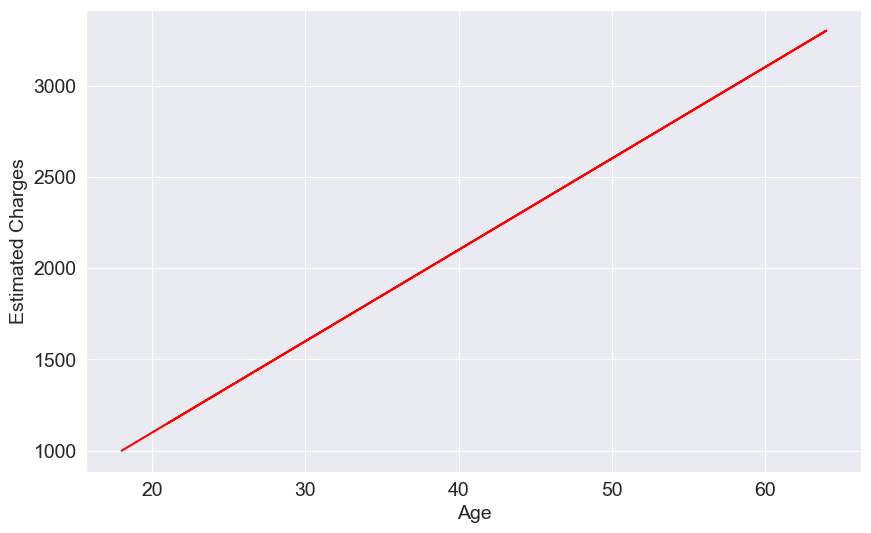

In [123]:
# this is our model prediction
plt.plot(ages, estimated_charges, 'r-') 
plt.xlabel('Age')
plt.ylabel('Estimated Charges')
plt.show()

As expected, the points lie on a straight line. 

We can overlay this line on the `actual data`, so see how well our model fits the data. 

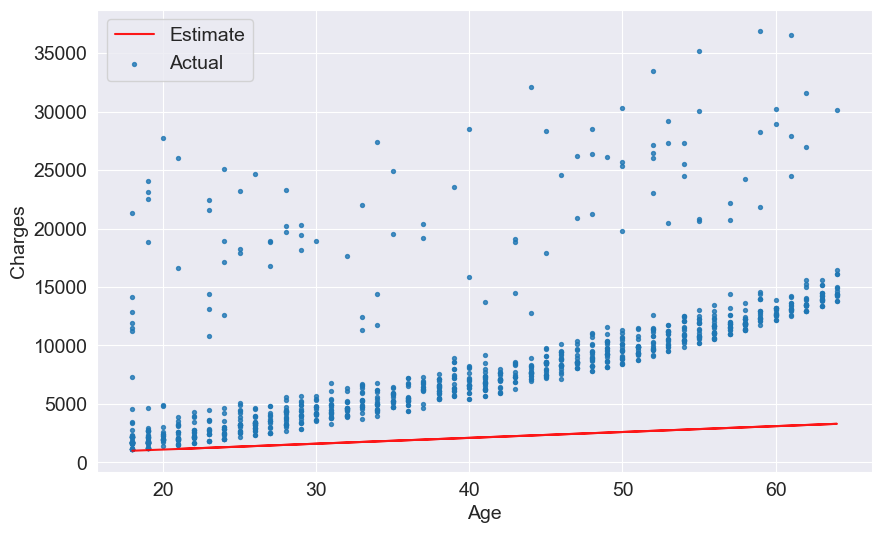

In [131]:
target = non_smoker_df.charges # this is the actual data 

plt.plot(ages, estimated_charges, 'r', alpha=0.9)
plt.scatter(ages,target,s=8,alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual'])
plt.show()

In [133]:
def try_parameters(w,b): 
    ages = non_smoker_df.age
    target = non_smoker_df.charges 

    estimated_charges = estimate_charges(ages, w, b)
    plt.plot(ages, estimated_charges, 'r', alpha=0.9)
    plt.scatter(ages,target,s=8,alpha=0.8)
    plt.xlabel('Age')
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual'])
    plt.show()

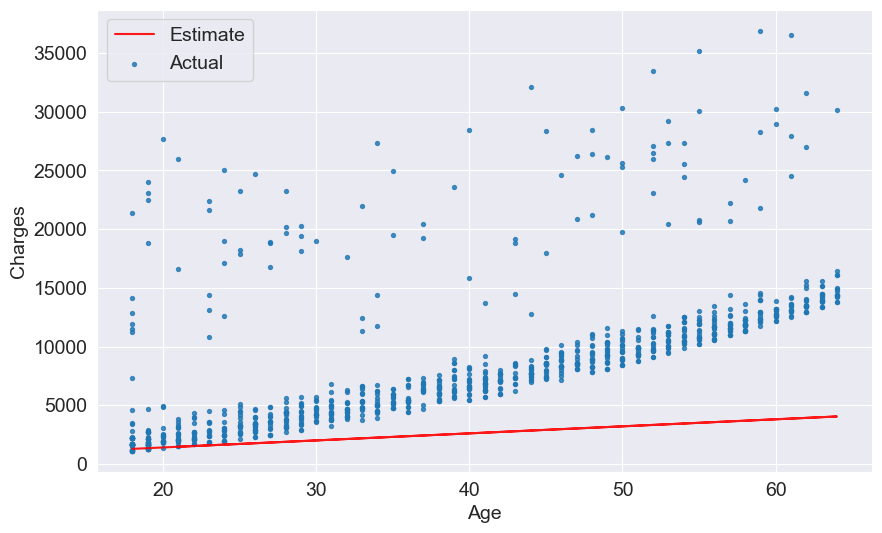

In [135]:
try_parameters(60,200)

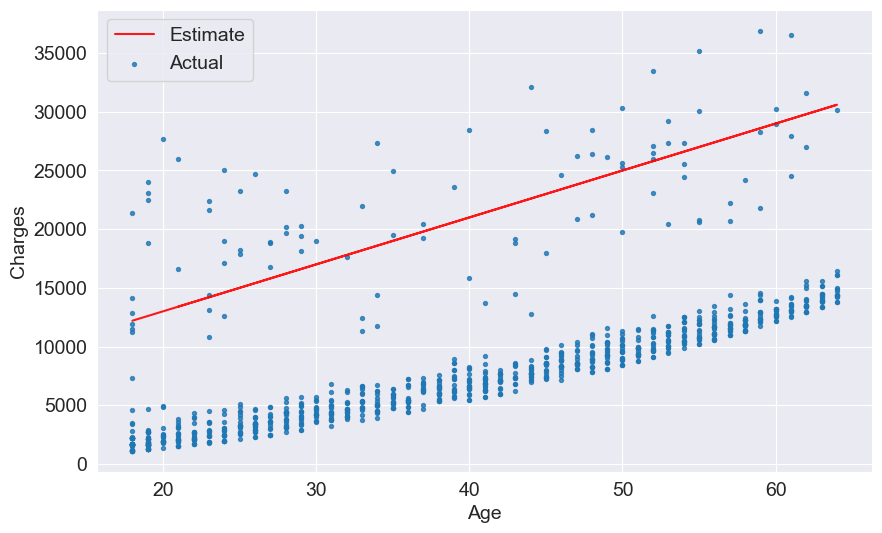

In [141]:
try_parameters(400,5000)

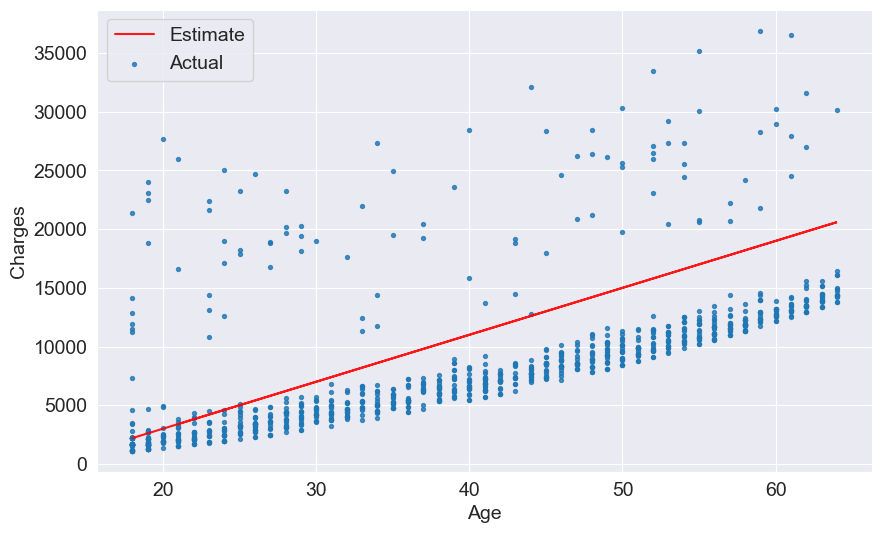

In [143]:
try_parameters(400,-5000)

 Wouldn't it be nice if a computer could try several different values of *w* and *b* and *learn* the relationship between "age" and "charges"? To do this, we need to solve a couple of problems:

1. We need a way to measure numerically how well the line fits the points.  
2. Once the "measure of fit" has been computed, we need a way to modify *w* and *b* to improve the the fit.

If we can solve the above problems, it should be possible for a computer to determine *w* and *b* for the best fit line, starting from a random guess.


### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

- Calculate the difference between the targets and predictions (the difference is called the "residual")  
- Square all elements of the difference matrix to remove negative values.  
- Calculate the average of the elements in the resulting matrix.  
- Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE). The above description can be stated mathematically as follows:

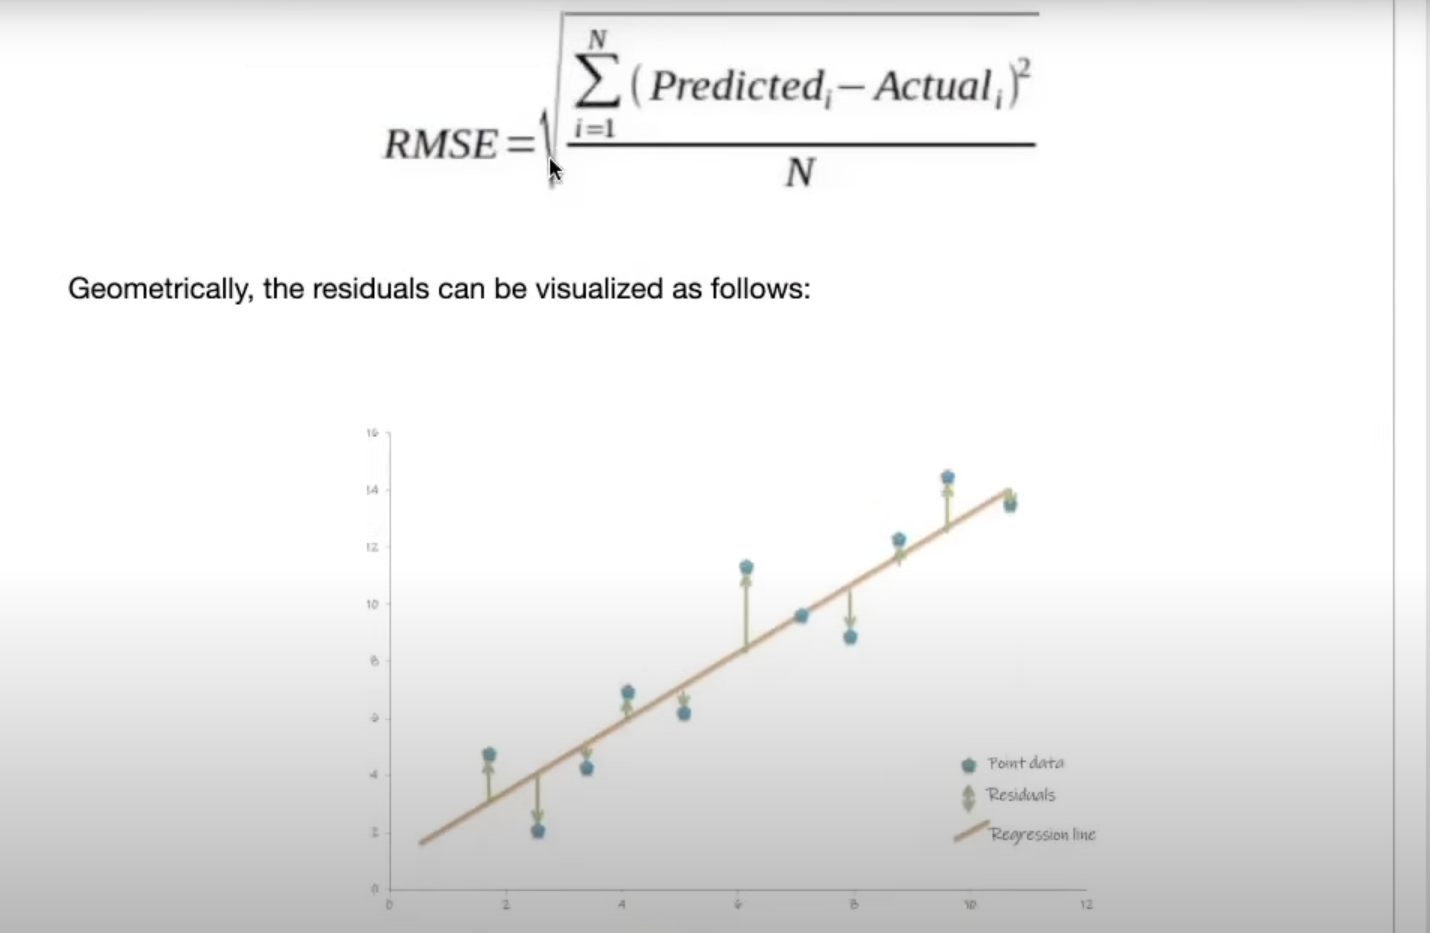

Let's define a function to compute RMSE. 


In [151]:
targets = non_smoker_df.charges 
targets

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

In [155]:
predictions = estimated_charges
predictions

1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64

In [221]:
import numpy as np 
def rmse(targets, predictions): 
    return np.sqrt(np.mean(np.square(targets - predictions)))

Let's compute the RMSE for our model with a sample set of weights 

In [224]:
w = 50
b = 100

RMSE Loss:  8461.949562575493


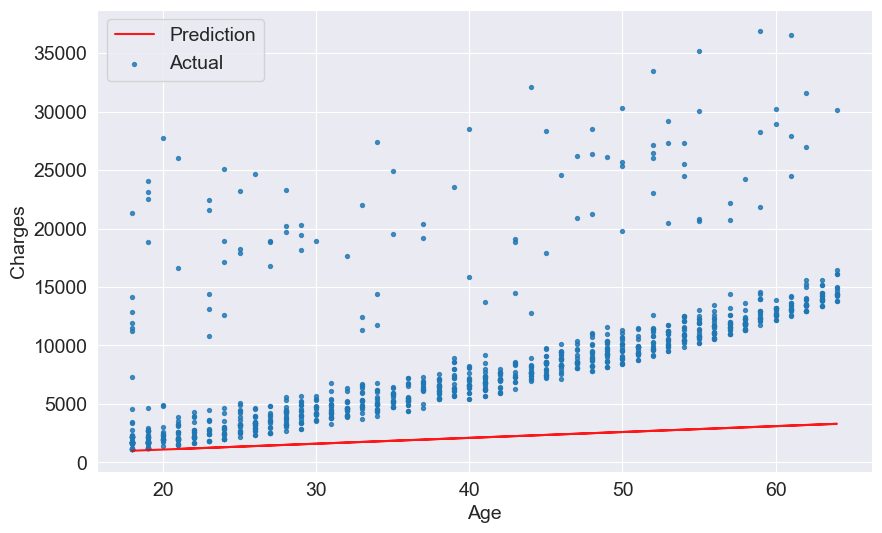

In [226]:
# target = (w * Age) + b
try_parameters(w,b)

In [228]:
target = non_smoker_df['charges']
predict = estimate_charges(non_smoker_df.age,w,b)

In [230]:
rmse(target,predict)

8461.949562575493

Here's how we can interpret the above number: *On average, each element in the prediction differs from the actual target by $8461.*

The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the `try_parameters` functions to also display the loss.


In [234]:
def try_parameters(w,b): 
    ages = non_smoker_df.age
    target = non_smoker_df.charges 
    predictions = estimate_charges(ages, w, b)

    plt.plot(ages, predictions, 'r', alpha=0.9)
    plt.scatter(ages,target,s=8,alpha=0.8)
    plt.xlabel('Age')
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual'])

    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)
    plt.show()

RMSE Loss:  4991.993804156943


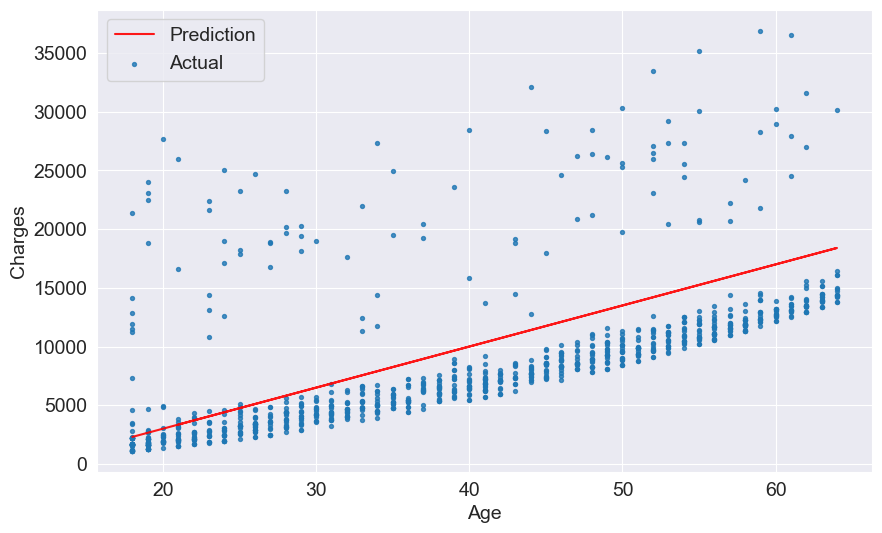

In [238]:
try_parameters(350,-4000)

### Optimizer

Next, we need a strategy to modify weights *w* and *b* to reduce the loss and improve the "fit" of the line to the data.

- Ordinary Least Squares: [https://www.youtube.com/watch?v=szXbuO3bVRk](https://www.youtube.com/watch?v=szXbuO3bVRk) (better for smaller datasets)  
- Stochastic gradient descent: [https://www.youtube.com/watch?v=sDv4f4s2SB8](https://www.youtube.com/watch?v=sDv4f4s2SB8) (better for larger datasets)  

Both of these have the same objective: to minimize the loss, however, while ordinary least squares directly computes the best values for `w` and `b` using matrix operations, while gradient descent uses an iterative approach, starting with a random values of `w` and `b` and slowly improving them using derivatives.


### Linear Regression using Scikit-learn
In practice, you'll never need to implement either of the above methods yourself. You can use a library like `scikit-learn` to do this for you.

Let's use the `LinearRegression` class from `scikit-learn` to find the best fit line for "age" vs. "charges" using the ordinary least squares optimization technique.

In [253]:
from sklearn.linear_model import LinearRegression

First, we create a new model object.

In [256]:
model = LinearRegression()

Next, we can use the `fit` method of the model to find the best fit line for the inputs and targets.

In [258]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data.

    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary.

    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample.

        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.

    Returns
    -------
    self : object
        Fitted Estimator.



Not that the input `x` must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [281]:
# model.fit requires an array because if you want to predict it with different features that's why, 
# but here we just want to predict it with one feature 'age' so we will provide a array with one element only, the age.
# if there are multiple features then we would have provided like this: 
# inputs = non_smoker_df[['age','bmi']] 

inputs = non_smoker_df[['age']] 
targets = non_smoker_df.charges
print('input.shape :', inputs.shape)
print('target.shape :', targets.shape)

input.shape : (1064, 1)
target.shape : (1064,)


In [283]:
model.fit(inputs,targets)

LinearRegression()

We can now make predictions using the model. Let's try predicting the charges for the ages 23, 37 and 61

In [288]:
# With one feature 'age'
model.predict(np.array([[23],[37],[61]]))

# With two features: 
# model.predict(np.array([[23,20],[37,40],[61,100]]))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([ 4055.30443855,  7796.78921819, 14210.76312614])

Do these values seem reasonable? Compare them with the scatter plot above.

Let compute the predictions for the entire set of inputs

In [295]:
predictions = model.predict(inputs)
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

Let's compute the RMSE loss to evaluate the model.

In [297]:
rmse(targets,predictions)

4662.505766636395

Seems like our prediction is off by $4000 on average, which is not too bad considering the fact

the parameters of the model are stored in the `coef_` and `intercept_` properties. 

In [300]:
# w 
model.coef_

array([267.24891283])

In [302]:
# b 
model.intercept_

-2091.420556565021

Are these parameters close to your best guesses?

Let's visualize the line created by the above parameters.

RMSE Loss:  4662.505766636395


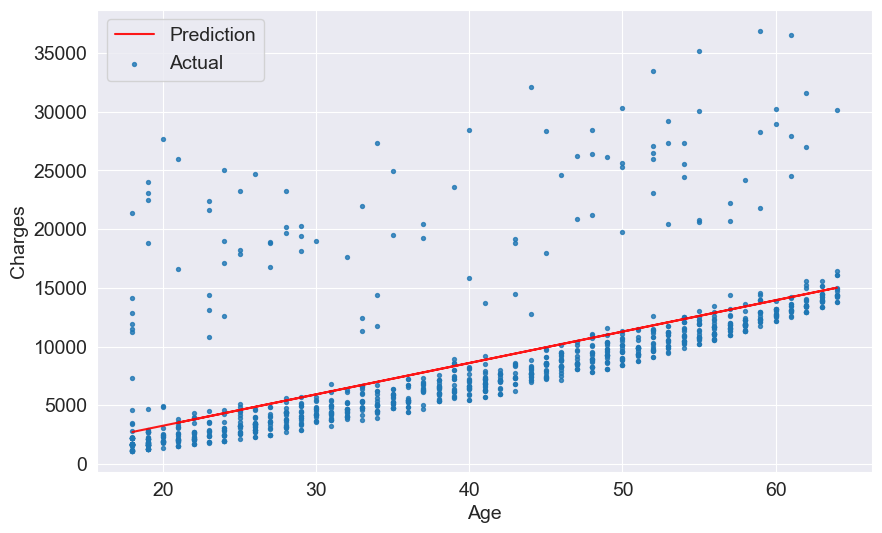

In [306]:
try_parameters(model.coef_,model.intercept_)

Indeed the line is quite close to the points. It is slightly above the cluster of points, because it's also trying to account for the outliers.

# Machine Learning

Congratulations, you've just trained your first *machine learning model*! Machine learning is simply the process of computing the best parameters to model the relationship between some feature and targets.

Every machine learning problem has three components:

1. **Model**  
2. **Cost Function**  
3. **Optimizer**  

We'll look at several examples of each of the above in future tutorials. Here's how the relationship between these three components can be visualized:
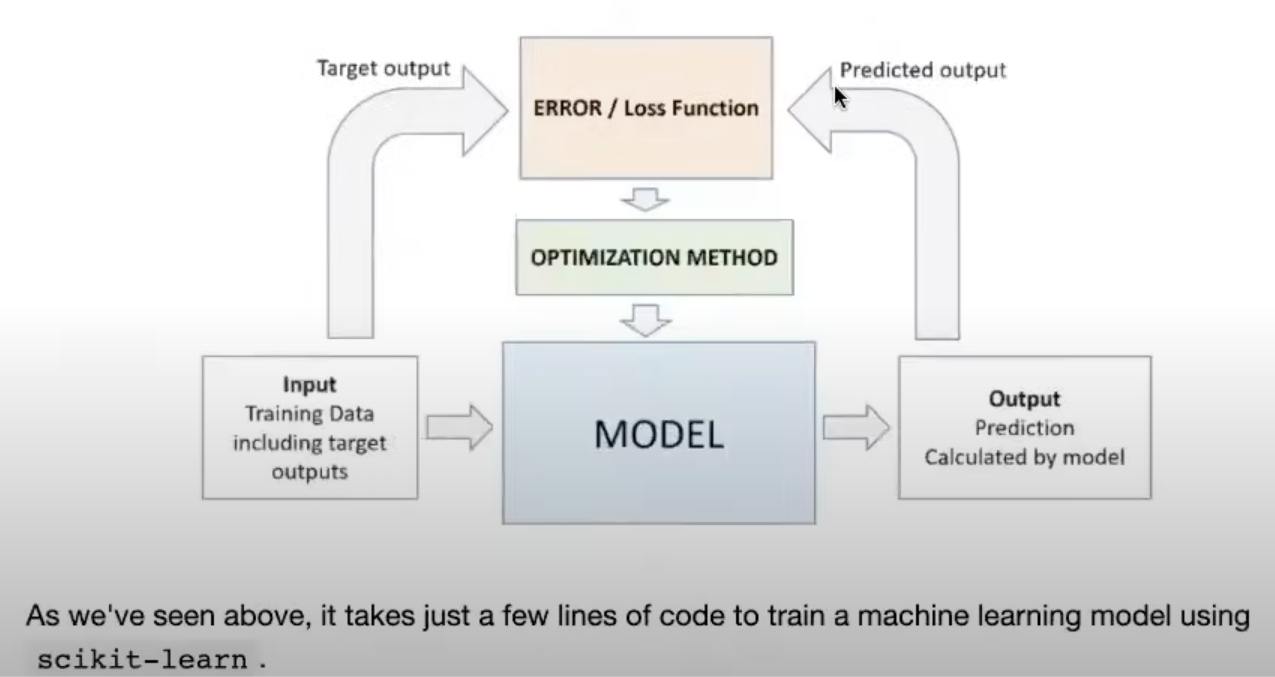


In [358]:
# For Non-Smokers 

# Create inputs and targets 
inputs, targets = non_smoker_df[['age']], non_smoker_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 4662.505766636395


In [360]:
# For Smokers 

smoker_df = medical_df[medical_df.smoker == 'yes']

# Create inputs and targets 
inputs, targets = smoker_df[['age']], smoker_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 10711.00334810241


# Linear Regression using Multiple Features

So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

$$
charges = w_1 \times age + w_2 \times bmi + b
$$

We need to change just one line of code to include the BMI.

In [364]:
# For Non-Smokers 

# Create inputs and targets 
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 4662.3128354612945


As you can see, adding the BMI doesn't seem to reduce the loss by much, as the BMI has a very weak correlation with charges, especially for non smokers.


In [369]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.08403654312833271

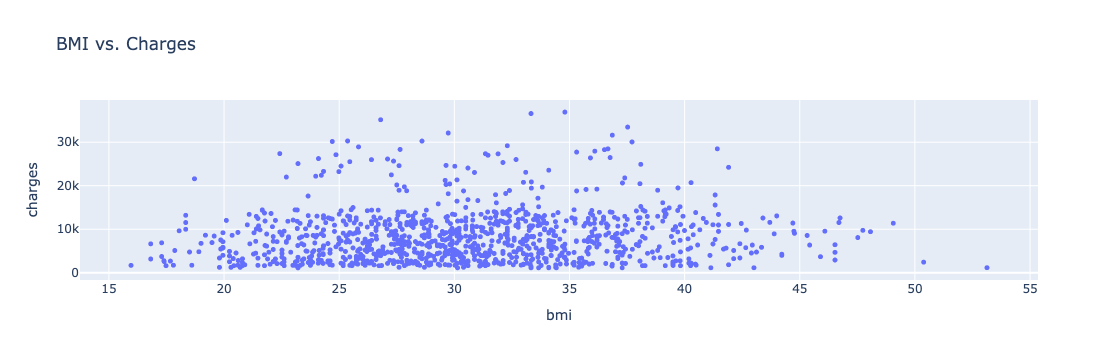

In [373]:
fig = px.scatter(non_smoker_df, x='bmi', y='charges', title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

In [375]:
model.coef_, model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488036)

Clearly, BMI has a much lower weightage, and you can see why. It has a tiny contribution, and even that is probably accidental. This is an important thing to keep in mind: you can't find a relationship that doesn't exist, no matter what machine learning technique or optimization algorithm you apply.

Let's go one step further, and add the final numeric column: "children", which seems to have some correlation with "charges".

$$
charges = w_1 \times age + w_2 \times bmi + w_3 \times charges + b
$$


In [379]:
non_smoker_df.charges.corr(non_smoker_df.children)

0.13892870453542205

In [381]:
# For Non-Smokers 

# Create inputs and targets 
inputs, targets = non_smoker_df[['age', 'bmi','children']], non_smoker_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 4608.470405038246


Let's just check our model behaviour on the entire data set and not just limit it to smoker or non-smoker. 

In [384]:
# For Non-Smokers 

# Create inputs and targets 
inputs, targets = medical_df[['age', 'bmi','children']], medical_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 11355.317901125973


The loss is much higher. And you can probably tell why when we do `PX dot scatter`. 

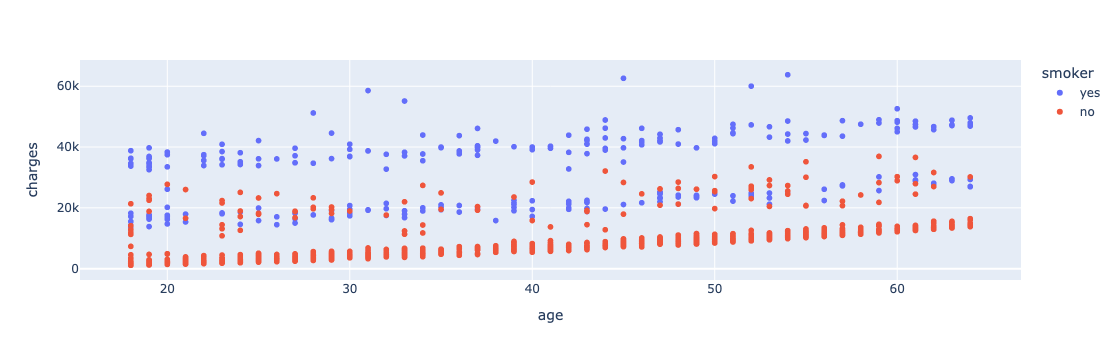

In [401]:
px.scatter(medical_df,x='age',y='charges',color='smoker')

 ## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.  
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.  
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals.

## Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".


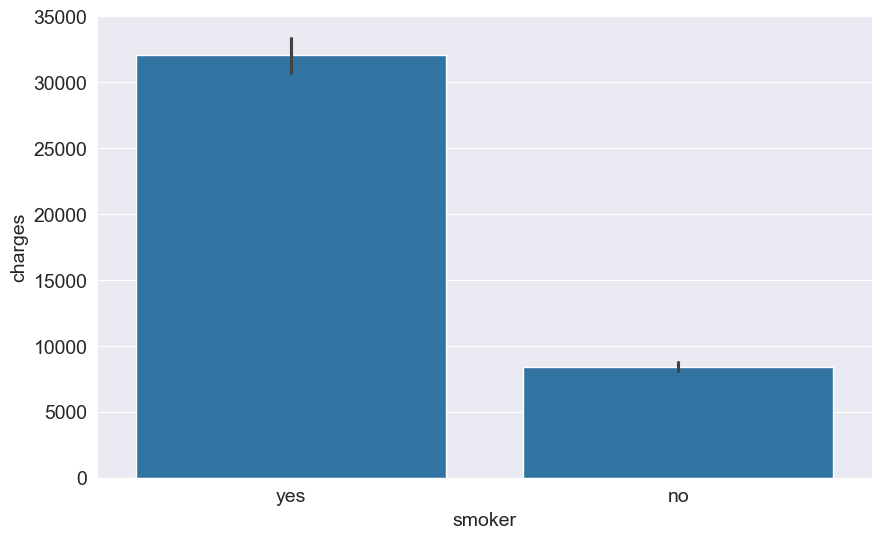

In [410]:
sns.barplot(data=medical_df, x='smoker', y='charges')
plt.show()

In [412]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [416]:
medical_df.charges.corr(medical_df.smoker_code)

0.7872514304984778

In [418]:
medical_df

age     sex     bmi  children smoker     region      charges  \
0      19  female  27.900         0    yes  southwest  16884.92400   
1      18    male  33.770         1     no  southeast   1725.55230   
2      28    male  33.000         3     no  southeast   4449.46200   
3      33    male  22.705         0     no  northwest  21984.47061   
4      32    male  28.880         0     no  northwest   3866.85520   
...   ...     ...     ...       ...    ...        ...          ...   
1333   50    male  30.970         3     no  northwest  10600.54830   
1334   18  female  31.920         0     no  northeast   2205.98080   
1335   18  female  36.850         0     no  southeast   1629.83350   
1336   21  female  25.800         0     no  southwest   2007.94500   
1337   61  female  29.070         0    yes  northwest  29141.36030   

      smoker_code  
0               1  
1               0  
2               0  
3               0  
4               0  
...           ...  
1333            0  
1334            0  
1335            0  
1336            0  
1337            1  

[1338 rows x 8 columns]

We can now use the `smoker_code` column for linear regression.

$$
charges = w_1 \times age + w_2 \times bmi + w_3 \times charges + w_4 \times smoker + b
$$


In [422]:
# Create inputs and targets 
inputs, targets = medical_df[['age', 'bmi','children', 'smoker_code']], medical_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 6056.439217188081


The loss reduces from `11355` to `6056`, almost by 50%! This is an important lesson: never ignore categorical data.

Let's try adding the "sex" column as well.

$$
charges = w_1 \times age + w_2 \times bmi + w_3 \times charges + w_4 \times smoker + w_5 \times sex + b
$$


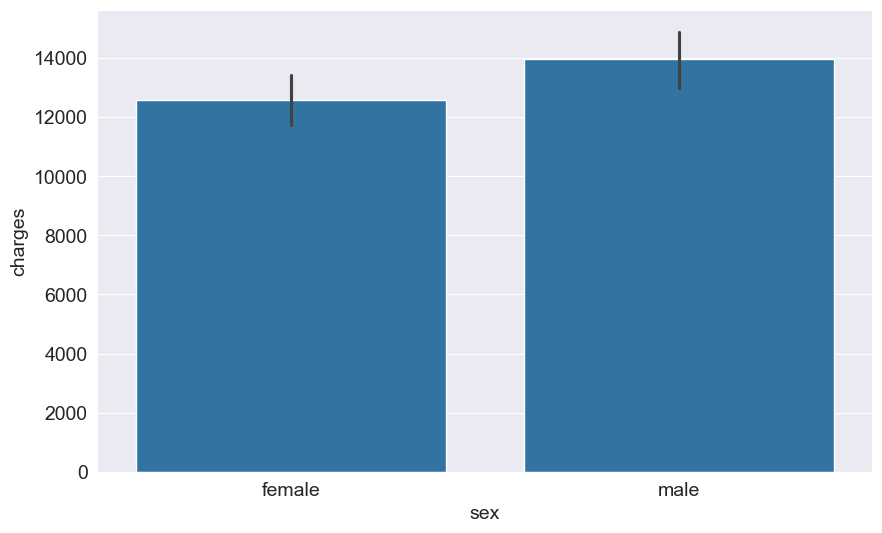

In [425]:
sns.barplot(data=medical_df, x='sex', y='charges')
plt.show()

In [427]:
sex_codes = {'female': 0, 'male': 1}
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [429]:
medical_df.charges.corr(medical_df.sex_code)

0.05729206220202533

In [431]:
# Create inputs and targets 
inputs, targets = medical_df[['age', 'bmi','children', 'smoker_code', 'sex_code']], medical_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 6056.100708754546


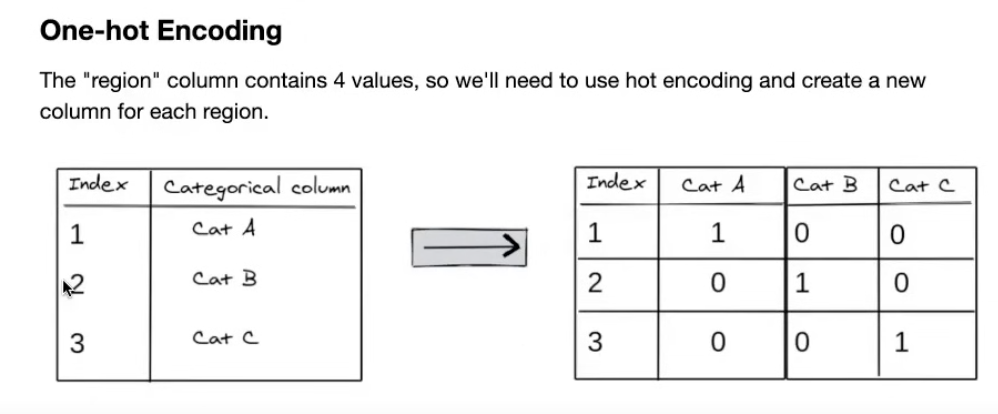

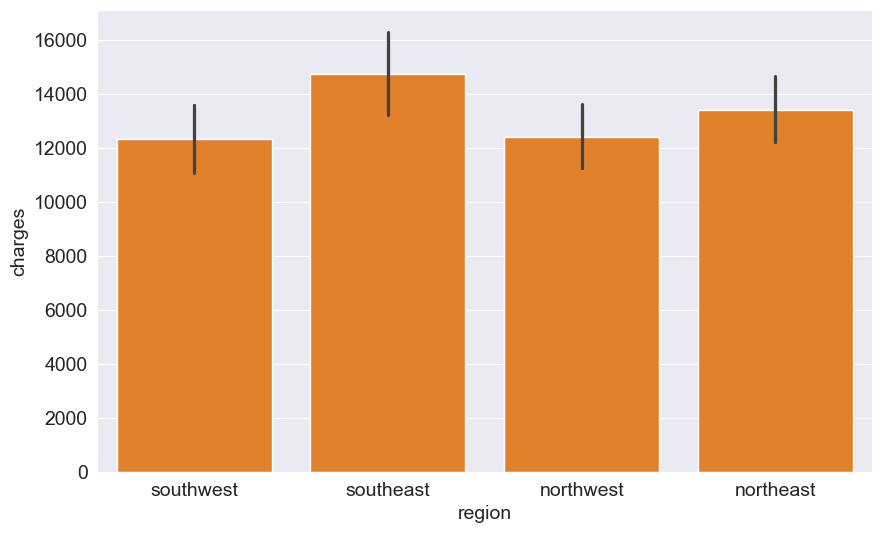

In [436]:
sns.barplot(data=medical_df, x='region',y='charges')
plt.show()

In [440]:
from sklearn import preprocessing 
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [444]:
#enc.transform([['northeast'],['northwest'],['southeast'],['southwest']]).toarray()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [448]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [452]:
medical_df[['northeast','northwest','southeast','southwest']] = one_hot

In [454]:
medical_df

age     sex     bmi  children smoker     region      charges  \
0      19  female  27.900         0    yes  southwest  16884.92400   
1      18    male  33.770         1     no  southeast   1725.55230   
2      28    male  33.000         3     no  southeast   4449.46200   
3      33    male  22.705         0     no  northwest  21984.47061   
4      32    male  28.880         0     no  northwest   3866.85520   
...   ...     ...     ...       ...    ...        ...          ...   
1333   50    male  30.970         3     no  northwest  10600.54830   
1334   18  female  31.920         0     no  northeast   2205.98080   
1335   18  female  36.850         0     no  southeast   1629.83350   
1336   21  female  25.800         0     no  southwest   2007.94500   
1337   61  female  29.070         0    yes  northwest  29141.36030   

      smoker_code  sex_code  northeast  northwest  southeast  southwest  
0               1         0        0.0        0.0        0.0        1.0  
1               0         1        0.0        0.0        1.0        0.0  
2               0         1        0.0        0.0        1.0        0.0  
3               0         1        0.0        1.0        0.0        0.0  
4               0         1        0.0        1.0        0.0        0.0  
...           ...       ...        ...        ...        ...        ...  
1333            0         1        0.0        1.0        0.0        0.0  
1334            0         0        1.0        0.0        0.0        0.0  
1335            0         0        0.0        0.0        1.0        0.0  
1336            0         0        0.0        0.0        0.0        1.0  
1337            1         0        0.0        1.0        0.0        0.0  

[1338 rows x 13 columns]

Let's include the region columns into our linear regression model.

$$
charges = w_1 \times age + w_2 \times bmi + w_3 \times charges + w_4 
\times smoker + w_5 \times sex + w_6 \times northeast + w_7 \times
northwest + w_8 \times southeast + w_9 \times southwest + b
$$


In [457]:
# Create inputs and targets 
input_cols = ['age', 'bmi','children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


In [469]:
# For Non-Smokers 
non_smoker_df =  medical_df[medical_df.smoker == 'no']
# Create inputs and targets 
inputs, targets = non_smoker_df[['age','bmi','children','sex_code', 'northeast', 'northwest', 'southeast', 'southwest']], non_smoker_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 4573.074988795492


In [471]:
# For Smokers 

smoker_df = medical_df[medical_df.smoker == 'yes']

# Create inputs and targets 
inputs, targets = smoker_df[['age','bmi','children','sex_code', 'northeast', 'northwest', 'southeast', 'southwest']], smoker_df['charges']

# Create and train the model 
model = LinearRegression().fit(inputs, targets)

# Generate predictions 
predictions = model.predict(inputs)

# Compute loss to evalute the model 
loss = rmse(targets,predictions)
print('Loss:', loss)

Loss: 5668.4678821121515


# Model Improvements

Let's discuss and apply some more improvements to our model.

## Feature Scaling

Recall that due to regulatory requirements, we also need to explain the rationale behind the predictions our model.

$$
charges = w_1 \times age + w_2 \times bmi + w_3 \times charges + w_4 \times smoker + w_5 \times sex + w_6 \times region + b
$$

To compare the importance of each feature in the model, our first instinct might be to compare their weights.


In [474]:
medical_df[input_cols].loc[10]

age            25.00
bmi            26.22
children        0.00
smoker_code     0.00
sex_code        1.00
northeast       1.00
northwest       0.00
southeast       0.00
southwest       0.00
Name: 10, dtype: float64

In [476]:
model.coef_

array([  267.40438625,  1475.54562981,   182.73655059,  -388.1216487 ,
         754.5850207 ,    64.86699592, -1138.15349664,   318.70148002])

In [478]:
model.intercept_

-23426.354338758905